Regime Model Greedy Gaussian Segmentation of Multivariate Time Series

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
import os
import sys
import time
import math
import random
import multiprocessing


from itertools import *
import numpy as np
import pandas as pd
from datetime import datetime
from sys import platform as _platform

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.dates import date2num
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

from utils.index_data import index_data

In [34]:
data_setting = {
    'start' : '1992-01-01',
    'end'   : '2021-06-30',
    'rebal_period':'1M'
}

data = index_data(**data_setting)
return_df = data.index_data_loading()
return_df = return_df.T
_return_df = np.array(return_df)

In [35]:
#Find K breakpoints on the data at a specific lambda
#Returns: The K breakpoints, along with all intermediate breakpoints (for k < K) and their corresponding
#   covariance-regularized maximum likelihoods
def GGS(data, Kmax, lamb, features = [], verbose = False):
    data = data.T
    #Select the desired features
    if (features == []):
        features = range(data.shape[1])
    data = data[:,features]
    m,n = data.shape

    #Initialize breakpoints
    breaks = [0,m+1]
    breakPoints = [breaks[:]]
    plotPoints = [calculateLikelihood(data, breaks,lamb)]

    #Start GGS Algorithm
    for z in range(Kmax):
        numBreaks = z+1
        newInd = -1
        newVal = +1
        #For each segment, find breakpoint and increase in LL
        for i in range(numBreaks):
            tempData = data[breaks[i]:breaks[i+1], :]
            ind, val = addBreak(tempData, lamb)
            if(val < newVal):
                newInd = ind + breaks[i]
                newVal = val

        #Check if our algorithm is finished
        if(newVal == 0):
            print("We are done adding breakpoints!")
            print(breaks)
            return breaks, plotPoints

        #Add new breakpoint
        breaks.append(newInd)
        breaks.sort()
        if (verbose == True):
            print("Breakpoint occurs at sample number: ", newInd, ", LL = ",  newVal)
            print(len(breaks) - 2, breaks)

        #Adjust current locations of the breakpoints
        breaks = adjustBreaks(data,breaks,[newInd],lamb,verbose)[:]

        #Calculate likelihood
        ll = calculateLikelihood(data,breaks,lamb)
        breakPoints.append(breaks[:])
        plotPoints.append(ll)

    return breakPoints, plotPoints

#Run cross-validation up to Kmax for a set of lambdas
#Return: train and test set likelihood for every K, lambda
def GGSCrossVal(data, Kmax=25, lambList = [0.1, 1, 10], features = [], verbose = False):
    data = data.T
    if (features == []):
        features = range(data.shape[1])
    data = data[:,features]
    origSize, n = data.shape

    np.random.seed(0)
    ordering = range(origSize)
    random.shuffle(ordering)

    trainTestResults = []

    #For each lambda, run the 10 folds in parallel
    numProcesses = min(multiprocessing.cpu_count(),10 )
    pool = multiprocessing.Pool(processes = numProcesses)
    for lamb in lambList:
        mseList = []
        trainList = []
        returnList = pool.map(multi_run_wrapper, [(0,data, Kmax, lamb, verbose, origSize, n, ordering),
            (1,data, Kmax, lamb, verbose, origSize, n, ordering),
            (2,data, Kmax, lamb, verbose, origSize, n, ordering),
            (3,data, Kmax, lamb, verbose, origSize, n, ordering),
            (4,data, Kmax, lamb, verbose, origSize, n, ordering),
            (5,data, Kmax, lamb, verbose, origSize, n, ordering),
            (6,data, Kmax, lamb, verbose, origSize, n, ordering),
            (7,data, Kmax, lamb, verbose, origSize, n, ordering),
            (8,data, Kmax, lamb, verbose, origSize, n, ordering),
            (9,data, Kmax, lamb, verbose, origSize, n, ordering)])

        #Accumulate results
        for i in range(10):
            for j in returnList[i][0]:
                mseList.append(j)
            for j in returnList[i][1]:
                trainList.append(j)

        #Get average of the 10 folds
        plotVals = map(list, zip(*mseList))
        maxBreaks = max(plotVals[0])+1
        testAvg = []
        for i in range(maxBreaks):
            num = 0
            runsum = 0
            for j in range(len(plotVals[0])):
                if (plotVals[0][j] == i):
                    runsum = runsum + plotVals[1][j]
                    num = num + 1
            testAvg.append(float(runsum)/num)
        plotVals2 = map(list, zip(*trainList))
        trainAvg = []
        for i in range(maxBreaks):
            num = 0
            runsum = 0
            for j in range(len(plotVals2[0])):
                if (plotVals[0][j] == i):
                    runsum = runsum + plotVals2[1][j]
                    num = num + 1
            trainAvg.append(float(runsum)/num)

        #Combine results for all lambdas into one list and return that
        trainTestResults.append((lamb, (trainAvg, testAvg)))

    return trainTestResults


#Find and return the means/regularized covariance of each segment for a given set of breakpoints
def GGSMeanCov(data, breakpoints, lamb, features = [], verbose = False):
    data = data.T
    #Select the desired features
    if (features == []):
        features = range(data.shape[1])
    data = data[:,features]
    m,n = data.shape

    numSegments = len(breakpoints) - 1
    mean_covs = []
    for i in range(numSegments):

        #Get mean and regularized covariance of current segment
        tempData = data[breakpoints[i]:breakpoints[i+1],:]
        m,n = tempData.shape
        empMean = np.mean(tempData, axis=0)
        empCov = np.cov(tempData.T,bias = True)
        regularizedCov = empCov + float(lamb)*np.identity(n)/m

        mean_covs.append((empMean, regularizedCov))

    return mean_covs


#HELPER FUNCTIONS
def calculateLikelihood(data, breaks,lamb):
    ll = 0
    for i in range(len(breaks) - 1):
        tempData = data[breaks[i]:breaks[i+1],:]
        m,n = tempData.shape
        empCov = np.cov(tempData.T,bias = True)
        ll = ll - (m*np.linalg.slogdet(empCov + float(lamb)*np.identity(n)/m)[1] - float(lamb) * np.trace(np.linalg.inv(empCov + float(lamb)*np.identity(n)/m)))
    return ll

def addBreak(data, lamb):
    #Initialize parameters
    m,n = data.shape
    origMean = np.mean(data, axis=0)
    origCov = np.cov(data.T,bias = True)
    origLL = m*np.linalg.slogdet(origCov + float(lamb)*np.identity(n)/m)[1] - float(lamb) * np.trace(np.linalg.inv(origCov + float(lamb)*np.identity(n)/m))
    totSum = m*(origCov+np.outer(origMean,origMean))
    muLeft = data[0,:]/n
    muRight = (m * origMean - data[0,:])/(m-1)
    runSum = np.outer(data[0,:],data[0,:])
    #Loop through all samples, find point where breaking the segment would have the largest LL increase
    minLL = origLL
    minInd = 0
    for i in range(2,m-1):
        #Update parameters
        runSum = runSum + np.outer(data[i-1,:],data[i-1,:])
        muLeft = ((i-1)*muLeft + data[i-1,:])/(i)
        muRight = ((m-i+1) * muRight - data[i-1,:])/(m-i)
        sigLeft = runSum/(i) - np.outer(muLeft, muLeft)
        sigRight = (totSum - runSum)/(m-i) - np.outer(muRight,muRight)

        #Compute Cholesky, LogDet, and Trace
        Lleft = np.linalg.cholesky(sigLeft + float(lamb)*np.identity(n)/i)
        Lright = np.linalg.cholesky(sigRight + float(lamb)*np.identity(n)/(m-i))
        llLeft = 2*sum(map(math.log, np.diag(Lleft)))
        llRight = 2*sum(map(math.log, np.diag(Lright)))
        (trLeft, trRight) = (0,0)
        if(lamb > 0):
            trLeft = math.pow(np.linalg.norm(np.linalg.inv(Lleft)),2)
            trRight = math.pow(np.linalg.norm(np.linalg.inv(Lright)),2)
        LL = i*llLeft - float(lamb)*trLeft + (m-i)*llRight - float(lamb)*trRight
        #Keep track of the best point so far
        if(LL < minLL):
            minLL = LL
            minInd = i
    #Return break, increase in LL
    return (minInd,minLL-origLL)

def adjustBreaks(data, breakpoints, newInd, lamb = 0, verbose = False, maxShuffles = 250):
    bp = breakpoints[:]
    random.seed(0)
    #Just one breakpoint, no need to adjust anything
    if (len(bp) == 3):
        return bp
    #Keep track of what breakpoints have changed, so that we don't have to adjust ones which we know are constant
    lastPass = dict()
    thisPass = dict()
    for b in bp:
        thisPass[b] = 0
    for i in newInd:
        thisPass[i] = 1
    for z in range(maxShuffles):
        lastPass = dict(thisPass)
        thisPass = dict()
        for b in bp:
            thisPass[b] = 0
        switchAny = False
        ordering = range(1,len(bp) - 1)

        random.sample(ordering, k=len(ordering))
        for i in ordering:
            #Check if we need to adjust it
            if(lastPass[bp[i-1]] == 1 or lastPass[bp[i+1]] == 1 or thisPass[bp[i-1]] == 1 or thisPass[bp[i+1]] == 1):
                tempData = data[bp[i-1]:bp[i+1], :]
                ind, val = addBreak(tempData, lamb)
                if (bp[i] != ind + bp[i-1] and val != 0):
                    lastPass[ind+bp[i-1]] = lastPass[bp[i]]
                    del lastPass[bp[i]]
                    del thisPass[bp[i]]
                    thisPass[ind+bp[i-1]] = 1
                    if (verbose == True):
                        print("Moving", bp[i], "to", ind+bp[i-1], "length = ", tempData.shape[0], ind)
                    bp[i] = ind + bp[i-1]
                    switchAny = True
        if (switchAny == False):
            return bp
    return bp

def multi_run_wrapper(args):
    return oneFold(*args)
def oneFold(fold, data, breakpoints, lamb, verbose, origSize, n, ordering):
    # Remove 10% of data for test set
    mseList = []
    trainList = []
    testSet = np.sort(ordering[(fold)*origSize/10:(fold+1)*origSize/10])
    mask = np.ones(origSize, dtype=bool)
    mask[testSet] = False
    trainData = data[mask,:]
    # Solve for test and train error
    testSize = len(testSet)
    trainSize = origSize - testSize
    bp = GGS(trainData.T, breakpoints, lamb, [], verbose)[0]
    for z in bp:
        i = z
        (mse, currBreak) = (0, 1)
        temp = trainData[0:i[1]]
        empMean = np.mean(temp, axis=0)
        empCov = np.cov(temp.T,bias = True) + float(lamb)*np.identity(n)/temp.shape[0]
        invCov = np.linalg.inv(empCov)
        #Calculate test error
        for j in range(testSize):
            #Find which break it's in
            adj = testSet[j] - j
            cb = max(sum(1 for k in i if k < adj),1)
            if (currBreak != cb):
                currBreak = cb
                temp = trainData[i[currBreak-1]:i[currBreak]]
                empMean = np.mean(temp, axis=0)
                empCov = np.cov(temp.T,bias = True) + float(lamb)*np.identity(n)/temp.shape[0]
                invCov = np.linalg.inv(empCov)
            #Compute likelihood
            ldet = 0.5*np.linalg.slogdet(invCov)[1]
            ll = ldet - 0.5*(data[testSet[j]] - empMean).dot(invCov).dot((data[testSet[j]] - empMean)) - n*math.log(2*math.pi)/2
            mse = mse+ll
        mseList.append((len(i)-2, mse/testSize))
        #Calculate training error
        tErr = 0
        currBreak = 1
        temp = trainData[0:i[1]]
        empMean = np.mean(temp, axis=0)
        empCov = np.cov(temp.T,bias = True) + float(lamb)*np.identity(n)/temp.shape[0]
        invCov = np.linalg.inv(empCov)
        for j in range(1,trainSize):
            if(j in i):
                currBreak = currBreak + 1
                temp = trainData[i[currBreak-1]:i[currBreak]]
                empMean = np.mean(temp, axis=0)
                empCov = np.cov(temp.T,bias = True) + float(lamb)*np.identity(n)/temp.shape[0]
                invCov = np.linalg.inv(empCov)
            #Compute likelihood
            ldet = 0.5*np.linalg.slogdet(invCov)[1]
            ll = ldet - 0.5*(trainData[j] - empMean).dot(invCov).dot((trainData[j] - empMean)) - n*math.log(2*math.pi)/2
            tErr = tErr+ll
        trainList.append((len(i)-2, tErr/trainSize))
    return mseList, trainList

In [38]:
# selected features' index of return_df
feats = [1,2,5,6,9,12]
# msci_world
# msci_emerging
# bb_world_agg
# bb_corp_hy
# us_short_treasury

In [39]:
bps, objectives = GGS(_return_df, Kmax = 10, lamb = 1e-4, features = feats)
bp10 = bps[10] # Get breakpoints for K = 10
bp10

In [41]:
meancovs = GGSMeanCov(_return_df, breakpoints = bp10, lamb = 1e-4, features = feats)

In [42]:
print("Breakpoints are at", bps)
print("Objectives are", objectives)

Breakpoints are at [[0, 355], [0, 97, 355], [0, 97, 218, 355], [0, 97, 201, 218, 355], [0, 97, 139, 186, 218, 355], [0, 97, 139, 186, 218, 322, 355], [0, 97, 139, 186, 203, 218, 322, 355], [0, 80, 97, 139, 186, 203, 218, 322, 355], [0, 80, 97, 139, 186, 203, 218, 248, 324, 355], [0, 80, 97, 139, 186, 203, 218, 248, 324, 342, 355], [0, 80, 97, 139, 186, 203, 207, 218, 248, 324, 342, 355]]
Objectives are [17171.232642634757, 18154.515696158316, 18445.562497417035, 18573.614640196425, 18710.83288723707, 18793.886249939806, 18867.104997447528, 18923.832696898917, 18976.13926494669, 19030.70872594358, 19086.266705174927]


In [43]:
data = index_data(**data_setting)
world_index = data.index_cum_data_loading()
world_index = world_index[['msci_world']]
world_index.columns = ['msci_world_cum']

,msci_world_cum
1992-01-31,1.000000
1992-02-29,0.979322
1992-03-31,0.962324
1992-04-30,0.898778
1992-05-31,0.923565
...,...
2021-02-28,5.039375
2021-03-31,5.199679
2021-04-30,5.305197
2021-05-31,5.507827


In [44]:
print(bp10)
world_index['regime'] = ''
i = 0
prev_bp = 0
for bp in bp10:
    world_index['regime'].iloc[prev_bp: bp] = i
    prev_bp = bp
    i = i + 1

world_index = world_index.reset_index()
world_index.columns = ['Date','msci_world_cum','regime']
world_index

[0, 80, 97, 139, 186, 203, 207, 218, 248, 324, 342, 355]


,Date,msci_world_cum,regime
0,1992-01-31,1.000000,1
1,1992-02-29,0.979322,1
2,1992-03-31,0.962324,1
3,1992-04-30,0.898778,1
4,1992-05-31,0.923565,1
...,...,...,...
349,2021-02-28,5.039375,11
350,2021-03-31,5.199679,11
351,2021-04-30,5.305197,11
352,2021-05-31,5.507827,11


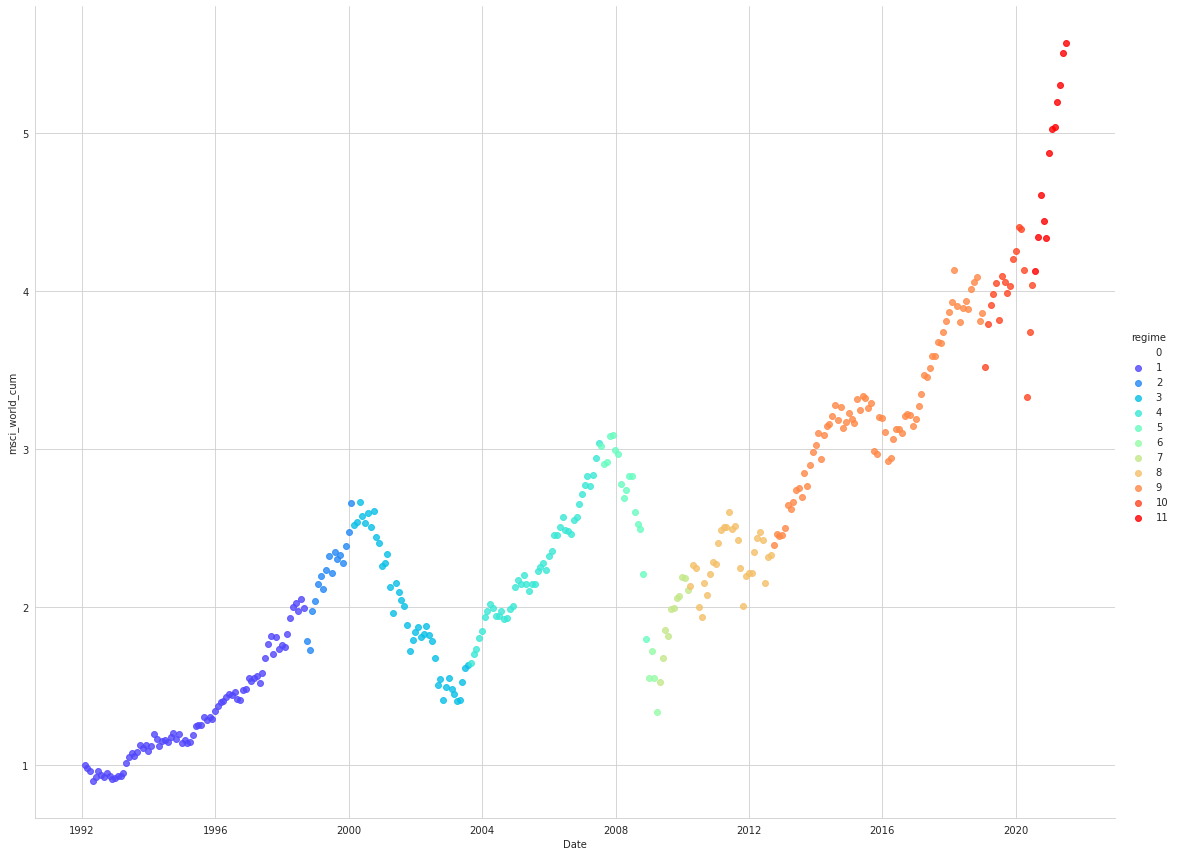

In [45]:
sns.set_style('whitegrid')
colors = cm.rainbow(np.linspace(0, 1, len(bp10)))
order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
fg = sns.FacetGrid(data=world_index, hue='regime', hue_order=order,
                   palette=colors, aspect=1.31, size=12)
fg.map(plt.scatter, 'Date', 'msci_world_cum', alpha=0.8).add_legend()